<a href="https://colab.research.google.com/github/Moong6/RL_Project/blob/main/RL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Install Korean font for matplotlib
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

# Configure matplotlib to use the new font
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # This is important to prevent minus signs from breaking

print("Korean font 'NanumGothic' installed and configured for Matplotlib.")
print("Please re-run your plotting cells to apply the changes.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [33]:
import numpy as np
import random
from collections import deque

import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt



# ============================================================
# 0. PyTorch device 설정 (GPU가 있으면 GPU 사용)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


수요는 고정값이 아니라,
요일(주말/평일) + 시즌(성수기/비수기) + 장기 추세 + 랜덤 요인을 모두 반영한 동적 패턴입니다.

예를 들어,

주말에는 평일보다 30% 더 많이 팔리고,

60일 주기로 성수기/비수기가 반복되며,

6개월 동안 전체 수요 수준이 서서히 증가하도록 설계했습니다.

이 위에 매일 0.8~1.2배의 랜덤 노이즈를 더해서,
현실에서 매출이 들쭉날쭉한 느낌을 강화학습 환경에 반영했습니다.

그리고 비용 구조는 이렇게 정리:

재고 1개를 하루 들고 있으면 0.5의 보유 비용이 들고,

한 개라도 못 팔면 50의 품절 패널티(기회손실 + 고객 불만)가 발생하며,

한 개를 사올 때는 20의 매입비용이 들고,

주문을 한 번 낼 때마다 1000의 고정 주문비용(트럭/인건비)이 들어갑니다.

따라서 에이전트는
“너무 많이 쌓아두지도, 너무 자주/너무 적게 주문하지도 않으면서, 품절도 최소화하는”
균형 잡힌 재고 정책을 스스로 학습해야 합니다.

In [34]:
# ============================================================
# 1. 스마트 물류 창고 환경 (WarehouseEnv)
#    - 대규모 스케일 (재고/수요 0 ~ 200,000)
#    - 리드타임 파이프라인, 품절 패널티 강화
#    - 상태는 0~1 범위로 정규화해서 반환
#    - 수요는 요일 + 시즌 + 추세 + 랜덤을 모두 반영한 동적 패턴
# ============================================================
class WarehouseEnv(gym.Env):
    def __init__(self,
                 min_lead_time=2,   # 최소 리드타임 (일)
                 max_lead_time=3    # 최대 리드타임 (일)
                 ):
        super(WarehouseEnv, self).__init__()

        # ---------- 리드타임 설정 ----------
        assert 1 <= min_lead_time <= max_lead_time, \
            "min_lead_time는 1 이상이고 max_lead_time보다 작거나 같아야 합니다."
        self.MIN_LEAD_TIME = min_lead_time
        self.MAX_LEAD_TIME = max_lead_time

        # ---------- 창고/수요 스케일 ----------
        self.MAX_CAPACITY = 200_000   # 창고 최대 용량
        self.MAX_DEMAND   = 200_000   # 하루 최대 수요 상한

        # ---------- 비용 구조 (현실감 있게 재설계) ----------
        # 재고 1개를 하루 들고 있을 때의 비용 (창고비, 자본비용 등)
        self.HOLDING_COST = 0.5

        # 품절 1개당 패널티 (잃어버린 마진 + 고객 불만 등)
        self.STOCKOUT_COST = 50.0

        # 상품 1개를 매입하는 데 드는 원가
        self.PURCHASE_COST = 20.0

        # 주문을 한 번 낼 때마다 드는 고정 비용 (트럭, 인력, 시스템 등)
        self.FIXED_ORDER_COST = 1_000.0

        # ---------- 행동(Action) 공간 ----------
        # 0, 10,000, 20,000, ..., 100,000 까지 11개 액션
        self.action_mapping = {i: i * 10_000 for i in range(11)}
        self.action_space   = spaces.Discrete(len(self.action_mapping))

        # ---------- 상태(State) 공간 ----------
        # 상태는 정규화된 값:
        #  [재고/용량, 전날 수요/최대수요, 요일/6,
        #   1일뒤입고/용량, ..., MAX_LEAD_TIME일뒤입고/용량]
        obs_dim = 3 + max_lead_time
        high = np.ones(obs_dim, dtype=np.float32)

        self.observation_space = spaces.Box(
            low=np.zeros_like(high),
            high=high,
            dtype=np.float32
        )

        # 리드타임 파이프라인 (raw 스케일)
        self.incoming_orders = np.zeros(self.MAX_LEAD_TIME, dtype=np.int32)

        # 한 에피소드는 180일
        self.max_steps = 180

        # 내부 상태 초기화
        self.reset()

    # -----------------------------
    # 환경 초기화
    # -----------------------------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # 초기 재고를 20%~60% 사이 랜덤으로 설정
        self.inventory = np.random.randint(
            int(0.2 * self.MAX_CAPACITY),
            int(0.6 * self.MAX_CAPACITY)
        )
        # 전날 수요도 랜덤 초기화
        self.prev_demand = np.random.randint(5_000, 25_000)
        # 시작 요일 (0~6) 랜덤
        self.day = np.random.randint(0, 7)
        # 진행된 일수
        self.steps = 0
        # 리드타임 파이프라인도 소량 랜덤
        self.incoming_orders = np.random.randint(
            0, 10_000, size=self.MAX_LEAD_TIME, dtype=np.int32
        )

        return self._get_obs(), {}

    # -----------------------------
    # 상태 벡터 생성 (정규화)
    # -----------------------------
    def _get_obs(self):
        inv_norm  = self.inventory   / self.MAX_CAPACITY
        prev_norm = self.prev_demand / self.MAX_DEMAND
        day_norm  = self.day / 6.0 if 6 > 0 else 0.0
        incoming_norm = self.incoming_orders / self.MAX_CAPACITY

        obs_list = [inv_norm, prev_norm, day_norm] + incoming_norm.tolist()
        return np.array(obs_list, dtype=np.float32)

    # -----------------------------
    # 확률적 수요 생성 (더 다이나믹한 패턴)
    #   - 요일 요인: 주말 > 평일
    #   - 시즌 요인: 60일 주기 성수기/비수기 (sin 파형)
    #   - 추세 요인: 180일 동안 서서히 증가
    #   - 랜덤 요인: 매일 0.8~1.2배 무작위
    # -----------------------------
    def _get_demand(self):
        # 기본 평일 기준 평균 수요
        base_demand = 12_000.0

        # (1) 시즌 요인: 60일 주기로 성수기/비수기 순환
        #   sin(2π * steps / 60) : -1 ~ 1
        #   → 1.0 ± 0.5 범위로 조정 (0.5 ~ 1.5)
        season_factor = 1.0 + 0.5 * np.sin(2 * np.pi * (self.steps / 60.0))

        # (2) 요일 요인: 주말(토,일)은 평일보다 30% 정도 더 많이
        if self.day >= 5:  # 토=5, 일=6
            weekday_factor = 1.3
        else:
            weekday_factor = 1.0

        # (3) 추세 요인: 시간이 지날수록 수요가 서서히 증가 (최대 +30%)
        trend_factor = 1.0 + 0.3 * (self.steps / max(1, self.max_steps))

        # (4) 랜덤 요인: 매일 0.8 ~ 1.2배 랜덤 변동
        random_factor = np.random.uniform(0.8, 1.2)

        # 최종 λ (포아송 평균)
        lam = base_demand * season_factor * weekday_factor * trend_factor * random_factor

        # 안정성을 위해 λ 범위 제한
        lam = max(1.0, min(lam, self.MAX_DEMAND))

        demand = np.random.poisson(lam)
        return int(min(demand, self.MAX_DEMAND))

    # -----------------------------
    # 하루(1 step) 진행
    # -----------------------------
    def step(self, action_idx):
        # 1) 오늘 도착 물량 재고 반영
        arriving_today = int(self.incoming_orders[0])
        self.inventory += arriving_today
        if self.inventory > self.MAX_CAPACITY:
            self.inventory = self.MAX_CAPACITY

        # 파이프라인 한 칸 앞으로 이동
        if self.MAX_LEAD_TIME > 1:
            self.incoming_orders[:-1] = self.incoming_orders[1:]
        self.incoming_orders[-1] = 0

        # 2) 주문 반영 (리드타임 랜덤)
        order_qty = self.action_mapping[action_idx]
        if order_qty > 0:
            lead_time = np.random.randint(self.MIN_LEAD_TIME,
                                          self.MAX_LEAD_TIME + 1)
            pipeline_idx = lead_time - 1
            self.incoming_orders[pipeline_idx] += order_qty

        # 3) 수요 발생 & 판매
        demand   = self._get_demand()
        sold     = min(self.inventory, demand)
        stockout = demand - sold
        self.inventory -= sold

        # 4) 비용 → 보상 (보다 현실적인 구조)
        holding_cost        = self.inventory * self.HOLDING_COST
        stockout_penalty    = stockout      * self.STOCKOUT_COST
        variable_order_cost = order_qty     * self.PURCHASE_COST
        fixed_order_cost    = self.FIXED_ORDER_COST if order_qty > 0 else 0.0

        total_cost = holding_cost + stockout_penalty + variable_order_cost + fixed_order_cost

        # 값이 너무 커지지 않도록 스케일링
        reward = - total_cost / 100_000.0

        # 5) 시간 / 상태 업데이트
        self.prev_demand = demand
        self.day = (self.day + 1) % 7
        self.steps += 1

        terminated = (self.steps >= self.max_steps)
        truncated  = False

        info = {
            "demand": demand,
            "stockout": stockout,
            "arriving_today": arriving_today,
            "sold": sold,
            "order_qty": order_qty
        }

        return self._get_obs(), reward, terminated, truncated, info


In [35]:
# ============================================================
# 2. Q-Network (상태 → 각 행동의 Q값)
#    - DQN: Q-learning을 신경망으로 근사
# ============================================================
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [36]:


# ============================================================
# 3. DQN 에이전트
#    - Double DQN
#    - Huber Loss (SmoothL1Loss)
#    - 타깃 네트워크 사용 (TD target 안정화)
#    - epsilon-greedy 탐험 전략
# ============================================================
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim  = state_dim
        self.action_dim = action_dim

        # ---------- 하이퍼파라미터 ----------
        self.gamma              = 0.99
        self.lr                 = 1e-4

        self.epsilon            = 1.0
        self.epsilon_min        = 0.02
        self.epsilon_decay      = 0.9998   # 곱셈식 감소

        self.batch_size         = 256
        self.target_update_freq = 5000     # 스텝 기준
        self.learn_start        = 50000     # 최소 경험 수
        self.buffer_size        = 100_000

        # Learning rate decay parameters
        self.lr_has_decayed     = False
        self.lr_decay_step      = 100000   # Decay LR after 100k steps
        self.lr_decay_factor    = 0.5      # Halve LR

        # ---------- 네트워크 ----------
        self.q_net      = QNetwork(state_dim, action_dim).to(device)
        self.target_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer  = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.loss_fn    = nn.SmoothL1Loss()  # Huber loss

        # ---------- 리플레이 버퍼 ----------
        self.memory = deque(maxlen=self.buffer_size)
        self.steps  = 0

    # -----------------------------
    # epsilon-greedy 정책
    # -----------------------------
    def select_action(self, state, eval_mode=False):
        if (not eval_mode) and (random.random() < self.epsilon):
            return random.randint(0, self.action_dim - 1)

        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state_t)
        return q_values.argmax(dim=1).item()

    # -----------------------------
    # 리플레이 버퍼에 저장
    # -----------------------------
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # -----------------------------
    # 한 스텝 학습 (Double DQN 업데이트)
    # -----------------------------
    def train_step(self):
        if len(self.memory) < max(self.batch_size, self.learn_start):
            return None

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states      = torch.FloatTensor(np.array(states)).to(device)
        actions     = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards     = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones       = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Q(s, a) 현재 값
        q_values = self.q_net(states)
        current_q = q_values.gather(1, actions)

        # ---------- Double DQN 타깃 ----------
        with torch.no_grad():
            # 온라인 네트워크로 다음 상태의 최적 행동 선택
            next_q_online = self.q_net(next_states)
            next_actions  = next_q_online.argmax(dim=1, keepdim=True)  # [B,1]

            # 타깃 네트워크에서 해당 행동의 Q값 사용
            next_q_target = self.target_net(next_states).gather(1, next_actions)

            target_q = rewards + self.gamma * next_q_target * (1 - dones)


        # ---------- 중간 이후 learning rate 줄이기 ----------
        if (not self.lr_has_decayed) and (self.steps >= self.lr_decay_step):
            for g in self.optimizer.param_groups:
                g['lr'] *= self.lr_decay_factor
                print(f"[LR Decay] step={self.steps}, new lr={g['lr']:.2e}")
            self.lr_has_decayed = True


        # ---------- 손실 계산 및 역전파 ----------
        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=1.0)
        self.optimizer.step()

        # ---------- epsilon 감소 ----------
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # ---------- 타깃 네트워크 업데이트 ----------
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()


In [37]:
# ============================================================
# 4. 환경 / 에이전트 생성 및 학습 루프
# ============================================================
env = WarehouseEnv(min_lead_time=2, max_lead_time=3)
state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

episodes = 600   # 각 에피소드 = 180일
scores   = []
losses   = []
loss_steps = []

best_avg_return = -1e9
best_model_state = None
ma_window = 20   # 이동 평균 윈도우

print(">>> DQN training start (large scale, 180 days/episode)...")
for ep in range(1, episodes + 1):
    state, _ = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)

        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.train_step()
        if loss is not None:
            losses.append(loss)
            loss_steps.append(agent.steps)

        state = next_state
        total_reward += reward

    scores.append(total_reward)

    # 최근 20 에피소드 이동 평균
    if len(scores) >= ma_window:
        recent_avg = np.mean(scores[-ma_window:])
        # best model 갱신
        if recent_avg > best_avg_return:
            best_avg_return = recent_avg
            best_model_state = agent.q_net.state_dict()

    if ep % 50 == 0:
        print(f"Episode {ep}/{episodes} | Total Reward: {total_reward:.2f} | "
              f"Epsilon: {agent.epsilon:.3f}")

print(f"\n>>> Best moving-average return (last {ma_window} episodes): {best_avg_return:.2f}")

# 학습 종료 후 best model 로드 (있다면)
if best_model_state is not None:
    agent.q_net.load_state_dict(best_model_state)
    print(">>> Loaded best model parameters.")


>>> DQN training start (large scale, 180 days/episode)...
Episode 50/600 | Total Reward: -2006.58 | Epsilon: 1.000
Episode 100/600 | Total Reward: -2072.56 | Epsilon: 1.000
Episode 150/600 | Total Reward: -1831.61 | Epsilon: 1.000
Episode 200/600 | Total Reward: -1952.10 | Epsilon: 1.000
Episode 250/600 | Total Reward: -1945.79 | Epsilon: 1.000
Episode 300/600 | Total Reward: -920.43 | Epsilon: 0.449
Episode 350/600 | Total Reward: -1134.77 | Epsilon: 0.074
Episode 400/600 | Total Reward: -844.00 | Epsilon: 0.020
Episode 450/600 | Total Reward: -594.65 | Epsilon: 0.020
Episode 500/600 | Total Reward: -565.77 | Epsilon: 0.020
Episode 550/600 | Total Reward: -565.03 | Epsilon: 0.020
Episode 600/600 | Total Reward: -592.57 | Epsilon: 0.020

>>> Best moving-average return (last 20 episodes): -571.89
>>> Loaded best model parameters.


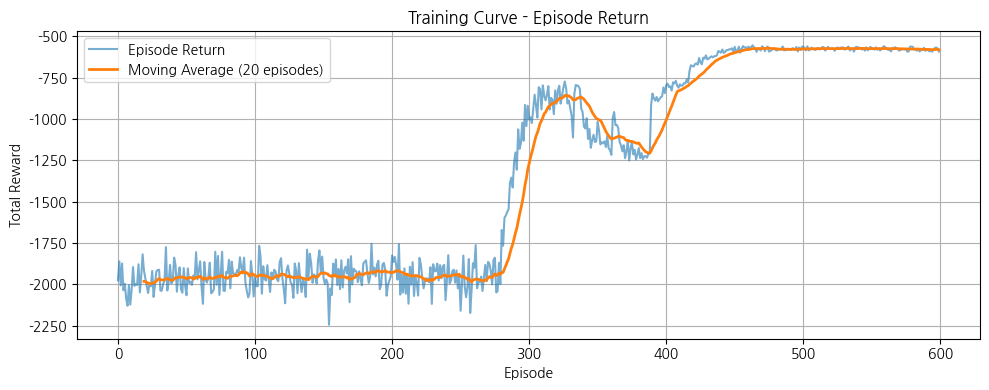

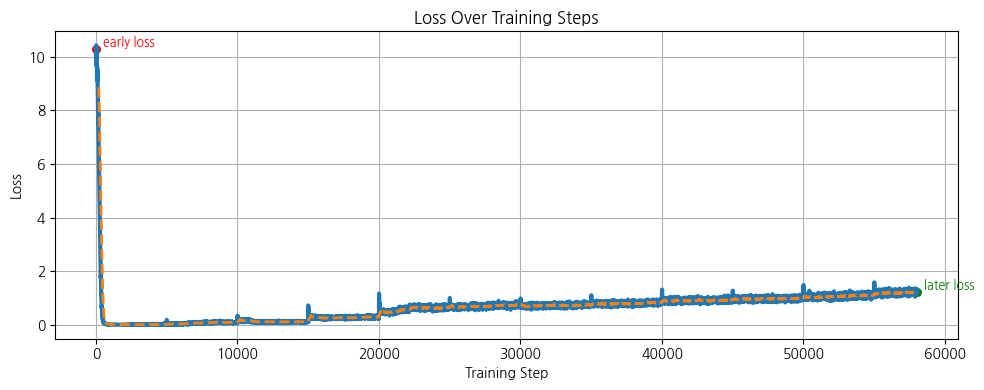

In [38]:
# ============================================================
# 5. 학습 곡선 시각화 (Training Curve / Loss)
# ============================================================

# (1) 에피소드별 총 보상 + 이동 평균
plt.figure(figsize=(10, 4))
plt.plot(scores, label='Episode Return', alpha=0.6)
if len(scores) >= ma_window:
    moving_avg = np.convolve(scores, np.ones(ma_window)/ma_window, mode='valid')
    plt.plot(range(ma_window-1, len(scores)), moving_avg,
             label=f'Moving Average ({ma_window} episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Curve - Episode Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (2) Loss over training steps + short / long moving average
plt.figure(figsize=(10, 4))

loss_arr = np.asarray(losses, dtype=np.float32)
step_arr = np.asarray(loss_steps, dtype=np.int32)

def moving_average_with_x(arr, x, window: int):
    """Compute moving average and corresponding x-axis."""
    if len(arr) < window:
        return arr, x[:len(arr)]
    ma = np.convolve(arr, np.ones(window) / window, mode='valid')
    x_ma = x[window-1:]
    return ma, x_ma

# short-term / long-term windows
short_window = 7
long_window  = 200

short_ma, short_x = moving_average_with_x(loss_arr, step_arr, short_window)
long_ma,  long_x  = moving_average_with_x(loss_arr, step_arr, long_window)

# 7-step moving average (short-term)
plt.plot(
    short_x, short_ma,
    linewidth=3,
    label=f'Short-term ({short_window}-step MA)'
)

# 200-step moving average (long-term trend)
if len(long_ma) > 0:
    plt.plot(
        long_x, long_ma,
        linewidth=2.0,
        linestyle='--',
        label=f'Long-term ({long_window}-step MA)'
    )

# Highlight start / end of short-term curve for intuition
if len(short_ma) > 0:
    # 초기 손실
    plt.scatter(short_x[0], short_ma[0], color='red', s=30)
    plt.text(
        short_x[0], short_ma[0],
        '  early loss',
        color='red', fontsize=9, va='bottom'
    )
    # 후반 손실
    plt.scatter(short_x[-1], short_ma[-1], color='green', s=30)
    plt.text(
        short_x[-1], short_ma[-1],
        '  later loss',
        color='green', fontsize=9, va='bottom'
    )

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss Over Training Steps')
plt.grid(True)
plt.tight_layout()
plt.show()


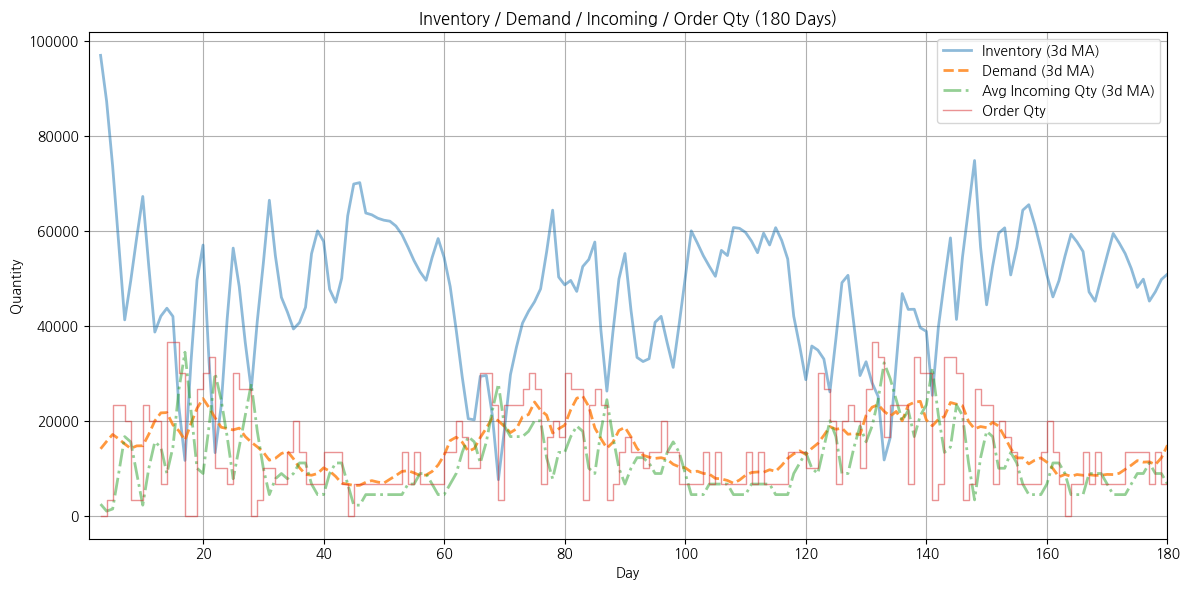

In [39]:
# ============================================================
# 6. 훈련된 에이전트 행동 시각화 (180일)
#    - Inventory / Demand / Avg Incoming / Order Qty
#    - raw 값 + 7일 이동 평균을 같이 표시
# ============================================================
state, _ = env.reset()
done = False

inventories  = []
demands      = []
orders       = []
incoming_avg = []

while not done:
    # 평가 모드: 탐험 없이 greedy 정책 사용
    action = agent.select_action(state, eval_mode=True)
    next_state, _, done, _, info = env.step(action)

    # raw 데이터 기록 (정규화가 아닌 "실제" 값을 보고 싶으면 역변환)
    # state[0]는 정규화된 재고량 → 실제 값으로 변환
    inv_real = state[0] * env.MAX_CAPACITY
    inventories.append(inv_real)
    demands.append(info["demand"])
    orders.append(env.action_mapping[action])

    # 파이프라인 평균(정규화된 값들을 실제 값으로 변환해서 평균)
    pipeline_norm = state[3:]
    if len(pipeline_norm) > 0:
        incoming_avg.append(pipeline_norm.mean() * env.MAX_CAPACITY)
    else:
        incoming_avg.append(0.0)

    state = next_state

days = np.arange(1, len(inventories) + 1)

def moving_average(arr, window=7):
    arr = np.asarray(arr, dtype=np.float32)
    if len(arr) < window:
        return arr, np.arange(1, len(arr) + 1)
    ma = np.convolve(arr, np.ones(window)/window, mode='valid')
    x  = np.arange(window, len(arr) + 1)
    return ma, x

# 7일 이동 평균 계산
inv_ma, x_inv = moving_average(inventories, window=3)
dem_ma, x_dem = moving_average(demands, window=3)
ord_ma, x_ord = moving_average(orders, window=3)
inc_ma, x_inc = moving_average(incoming_avg, window=3)

plt.figure(figsize=(12, 6))

'''
# --- raw 값 (연한 색) ---
plt.plot(days, inventories, label='Inventory (raw)', alpha=0.25)
plt.plot(days, demands, label='Demand (raw)', alpha=0.25)
plt.plot(days, incoming_avg, label='Avg Incoming Qty (raw)', alpha=0.25)
plt.step(days, orders, where='post', label='Order Qty (raw)', alpha=0.25)
'''

# --- 7일 이동 평균 (굵은 선) ---
plt.plot(x_inv, inv_ma, label='Inventory (3d MA)', linewidth=2, alpha=0.5)
plt.plot(x_dem, dem_ma, label='Demand (3d MA)', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(x_inc, inc_ma, label='Avg Incoming Qty (3d MA)', linestyle='-.', linewidth=2, alpha=0.5)
plt.step(x_ord, ord_ma, where='post', label='Order Qty', linewidth=1, alpha=0.5)

plt.xlabel('Day')
plt.ylabel('Quantity')
plt.title('Inventory / Demand / Incoming / Order Qty (180 Days)')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlim(1, len(inventories))
plt.tight_layout()
plt.show()
